In [1]:
import pandas as pd
from scipy.stats import pearsonr
import datetime

import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import holidays
import seaborn as sns
from prophet import Prophet
import math
from sklearn.metrics import mean_squared_error

from typing import Optional, Any, Tuple, List

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


In [2]:
load_data_path = 'processed_data/data_2006_2023.csv'
regional_data_path = 'processed_data/resedentialEnergyData(Provincies).csv'

In [3]:
load_data = pd.read_csv(load_data_path)
load_data.head()

,loadConsumption,date,datetime,Hour,Year
0,10215.0,2006-01-01,2005-12-31 23:00:00,0,2006
1,9979.0,2006-01-01,2006-01-01 00:00:00,1,2006
2,9460.0,2006-01-01,2006-01-01 01:00:00,2,2006
3,8833.0,2006-01-01,2006-01-01 02:00:00,3,2006
4,8525.0,2006-01-01,2006-01-01 03:00:00,4,2006


In [4]:
#loadConsumption.head()

# Ensure 'datetime' is in datetime format
load_data['datetime'] = pd.to_datetime(load_data['datetime'], errors='coerce')

# Group by the date and sum up the load consumption
daily_loadConsumption = load_data.groupby(load_data['datetime'].dt.date).agg({'loadConsumption': 'sum'}).reset_index()

daily_loadConsumption.rename(columns={'datetime': 'Date', 'loadConsumption': 'DailyLoadConsumption'}, inplace=True)



In [5]:
daily_loadConsumption.head()

,Date,DailyLoadConsumption
0,2005-12-31,10215.0
1,2006-01-01,254397.0
2,2006-01-02,316137.0
3,2006-01-03,326106.0
4,2006-01-04,328600.0


In [6]:
# Group by year and month, summing up the load consumption
monthly_loadConsumption = load_data.groupby(load_data['datetime'].dt.to_period('M'))['loadConsumption'].sum().reset_index()

# Rename columns for clarity
monthly_loadConsumption.rename(columns={'datetime': 'Month', 'loadConsumption': 'MonthlyLoadConsumption'}, inplace=True)

# Convert 'Month' to datetime for proper formatting
monthly_loadConsumption['Month'] = monthly_loadConsumption['Month'].astype(str)



In [7]:
monthly_loadConsumption.head()

,Month,MonthlyLoadConsumption
0,2005-12,10215.0
1,2006-01,9724813.0
2,2006-02,8570834.0
3,2006-03,9608934.0
4,2006-04,8834572.0


In [8]:
residential_energy_data = pd.read_csv(regional_data_path)
residential_energy_data.head()

,Housing characteristics,Year,Regions,AvgGasConsumptionResedetial,AvgElectricitySupplyResedential
0,Total dwellings,2010,The Netherlands,1850.0,3300.0
1,Total dwellings,2011,The Netherlands,1450.0,3250.0
2,Total dwellings,2012,The Netherlands,1500.0,3200.0
3,Total dwellings,2013,The Netherlands,1600.0,3150.0
4,Total dwellings,2014,The Netherlands,1200.0,3050.0


In [9]:
# Check for missing values in the residential energy dataset
missing_values = residential_energy_data.isnull().sum()

missing_values

Housing characteristics             0
Year                                0
Regions                             0
AvgGasConsumptionResedetial        26
AvgElectricitySupplyResedential    26
dtype: int64

In [10]:
# Display rows where there are missing values in the residential energy dataset
missing_rows = residential_energy_data[residential_energy_data.isnull().any(axis=1)]


missing_rows

,Housing characteristics,Year,Regions,AvgGasConsumptionResedetial,AvgElectricitySupplyResedential
338,Owner-occupied house,2010,The Netherlands,NaN,NaN
339,Owner-occupied house,2011,The Netherlands,NaN,NaN
351,Owner-occupied house,2010,Groningen (PV),NaN,NaN
352,Owner-occupied house,2011,Groningen (PV),NaN,NaN
364,Owner-occupied house,2010,Fryslân (PV),NaN,NaN
365,Owner-occupied house,2011,Fryslân (PV),NaN,NaN
377,Owner-occupied house,2010,Drenthe (PV),NaN,NaN
378,Owner-occupied house,2011,Drenthe (PV),NaN,NaN
390,Owner-occupied house,2010,Overijssel (PV),NaN,NaN
391,Owner-occupied house,2011,Overijssel (PV),NaN,NaN


In [11]:
residential_energy_data = residential_energy_data.dropna()

In [12]:
# Creating a dictionary of DataFrames, where keys are region names
regions_dfs = {region: df for region, df in residential_energy_data.groupby("Regions")}

# Accessing a specific region's DataFrame (example for 'The Netherlands')
netherlands_df = regions_dfs.get("The Netherlands")

# Display the first few rows of the Netherlands DataFrame
netherlands_df.head()


,Housing characteristics,Year,Regions,AvgGasConsumptionResedetial,AvgElectricitySupplyResedential
0,Total dwellings,2010,The Netherlands,1850.0,3300.0
1,Total dwellings,2011,The Netherlands,1450.0,3250.0
2,Total dwellings,2012,The Netherlands,1500.0,3200.0
3,Total dwellings,2013,The Netherlands,1600.0,3150.0
4,Total dwellings,2014,The Netherlands,1200.0,3050.0


In [13]:
populationNL_path = 'processed_data/populationNL.csv'
populationNL = pd.read_csv(populationNL_path)
populationNL.head()

,Year,Population
0,2006,"16,33"
1,2007,"16,36"
2,2008,"16,41"
3,2009,"16,49"
4,2010,"16,57"


In [14]:
merged_data = populationNL.merge(netherlands_df, on = 'Year')

In [15]:
merged_data

,Year,Population,Housing characteristics,Regions,AvgGasConsumptionResedetial,AvgElectricitySupplyResedential
0,2010,"16,57",Total dwellings,The Netherlands,1850.0,3300.0
1,2010,"16,57",Apartment,The Netherlands,1200.0,2250.0
2,2011,"16,66",Total dwellings,The Netherlands,1450.0,3250.0
3,2011,"16,66",Apartment,The Netherlands,950.0,2250.0
4,2012,"16,73",Total dwellings,The Netherlands,1500.0,3200.0
5,2012,"16,73",Apartment,The Netherlands,1000.0,2250.0
6,2012,"16,73",Owner-occupied house,The Netherlands,1750.0,3750.0
7,2013,"16,78",Total dwellings,The Netherlands,1600.0,3150.0
8,2013,"16,78",Apartment,The Netherlands,1050.0,2200.0
9,2013,"16,78",Owner-occupied house,The Netherlands,1850.0,3700.0


In [16]:
# Pivot the table so that "Housing characteristics" become columns
reshaped_df = merged_data.pivot_table(
    index=['Year', 'Population'], 
    columns='Housing characteristics', 
    values=['AvgGasConsumptionResedetial', 'AvgElectricitySupplyResedential']
)

# Flatten the MultiIndex columns
reshaped_df.columns = ['_'.join(col).strip() for col in reshaped_df.columns.values]

# Reset the index to make it a proper DataFrame
reshaped_df.reset_index(inplace=True)

In [17]:
reshaped_df

,Year,Population,AvgElectricitySupplyResedential_Apartment,AvgElectricitySupplyResedential_Owner-occupied house,AvgElectricitySupplyResedential_Total dwellings,AvgGasConsumptionResedetial_Apartment,AvgGasConsumptionResedetial_Owner-occupied house,AvgGasConsumptionResedetial_Total dwellings
0,2010,"16,57",2250.0,NaN,3300.0,1200.0,NaN,1850.0
1,2011,"16,66",2250.0,NaN,3250.0,950.0,NaN,1450.0
2,2012,"16,73",2250.0,3750.0,3200.0,1000.0,1750.0,1500.0
3,2013,"16,78",2200.0,3700.0,3150.0,1050.0,1850.0,1600.0
4,2014,"16,83",2150.0,3550.0,3050.0,800.0,1400.0,1200.0
5,2015,"16,90",2120.0,3480.0,2980.0,840.0,1480.0,1250.0
6,2016,"16,98",2070.0,3400.0,2910.0,870.0,1530.0,1300.0
7,2017,"17,08",2050.0,3330.0,2860.0,840.0,1470.0,1240.0
8,2018,"17,18",2010.0,3250.0,2790.0,830.0,1480.0,1270.0
9,2019,"17,28",1970.0,3180.0,2730.0,770.0,1370.0,1180.0


In [18]:
final_consumption_path = 'processed_data/yearlyfinalConsPerSource.csv'

In [19]:
final_consumption = pd.read_csv(final_consumption_path)

In [20]:
final_consumption.head()

,Year,"Crude, NGL and feedstocks",Electricity,Heat,Natural gas,Oil products,Renewables and waste,Total
0,2006,152.811999,380.073969,134.426999,898.165922,1008.011163,31.096825,2628.186508
1,2007,125.816020,387.903574,134.095999,846.718658,1014.433777,44.011474,2578.530834
2,2008,122.583998,390.324855,133.068001,885.718461,965.519794,43.982652,2562.009478
3,2009,118.556020,376.760879,119.710999,887.152712,952.343462,48.035018,2524.642987
4,2010,116.968017,387.511372,125.607002,1032.772229,1008.902880,42.375440,2732.806011


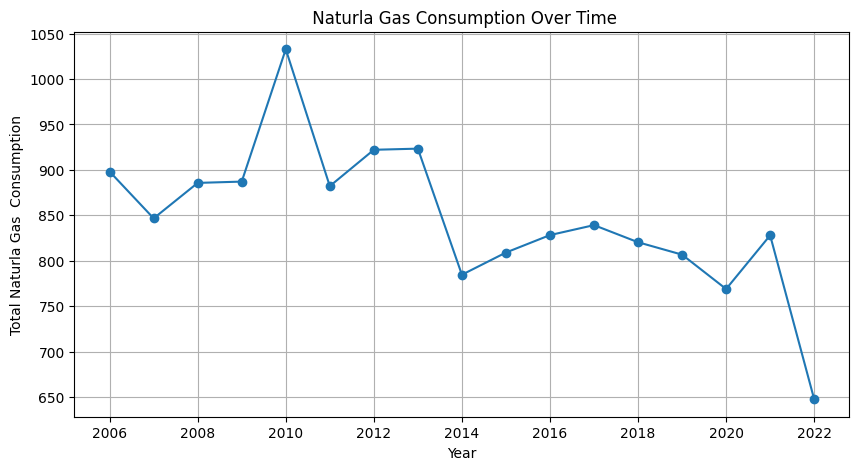

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(final_consumption['Year'], final_consumption['Natural gas'], marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Total Naturla Gas  Consumption")
plt.title(" Naturla Gas Consumption Over Time")
plt.grid(True)
plt.show()


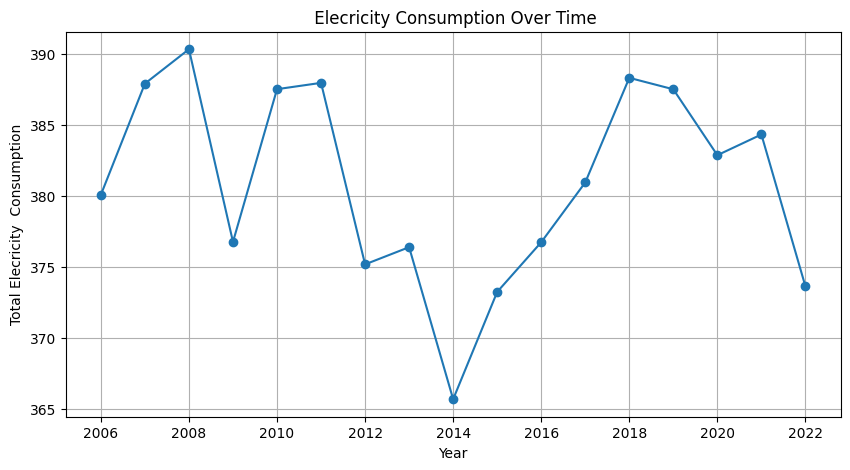

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(final_consumption['Year'], final_consumption['Electricity'], marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Total Elecricity  Consumption")
plt.title(" Elecricity Consumption Over Time")
plt.grid(True)
plt.show()


In [23]:
columns = ['Year', 'Electricity', 'Total']
final_consumption = final_consumption[columns]

In [24]:
final_consumption = final_consumption.rename(columns={'Total': 'TotalEnergyConsumption', 'Electricity': 'ElectricityConsumption'})


In [25]:
final_consumption.head()

,Year,ElectricityConsumption,TotalEnergyConsumption
0,2006,380.073969,2628.186508
1,2007,387.903574,2578.530834
2,2008,390.324855,2562.009478
3,2009,376.760879,2524.642987
4,2010,387.511372,2732.806011


In [26]:
merged_data_2 = reshaped_df.merge(final_consumption, on = 'Year')

In [27]:
merged_data_2

,Year,Population,AvgElectricitySupplyResedential_Apartment,AvgElectricitySupplyResedential_Owner-occupied house,AvgElectricitySupplyResedential_Total dwellings,AvgGasConsumptionResedetial_Apartment,AvgGasConsumptionResedetial_Owner-occupied house,AvgGasConsumptionResedetial_Total dwellings,ElectricityConsumption,TotalEnergyConsumption
0,2010,"16,57",2250.0,NaN,3300.0,1200.0,NaN,1850.0,387.511372,2732.806011
1,2011,"16,66",2250.0,NaN,3250.0,950.0,NaN,1450.0,387.956449,2530.077378
2,2012,"16,73",2250.0,3750.0,3200.0,1000.0,1750.0,1500.0,375.176334,2557.834447
3,2013,"16,78",2200.0,3700.0,3150.0,1050.0,1850.0,1600.0,376.386709,2508.137131
4,2014,"16,83",2150.0,3550.0,3050.0,800.0,1400.0,1200.0,365.681246,2309.636765
5,2015,"16,90",2120.0,3480.0,2980.0,840.0,1480.0,1250.0,373.236289,2333.886363
6,2016,"16,98",2070.0,3400.0,2910.0,870.0,1530.0,1300.0,376.734289,2400.623147
7,2017,"17,08",2050.0,3330.0,2860.0,840.0,1470.0,1240.0,380.944975,2448.317351
8,2018,"17,18",2010.0,3250.0,2790.0,830.0,1480.0,1270.0,388.309321,2419.494147
9,2019,"17,28",1970.0,3180.0,2730.0,770.0,1370.0,1180.0,387.504543,2356.396676


In [28]:
print(merged_data_2.isnull().sum())


Year                                                    0
Population                                              0
AvgElectricitySupplyResedential_Apartment               0
AvgElectricitySupplyResedential_Owner-occupied house    2
AvgElectricitySupplyResedential_Total dwellings         0
AvgGasConsumptionResedetial_Apartment                   0
AvgGasConsumptionResedetial_Owner-occupied house        2
AvgGasConsumptionResedetial_Total dwellings             0
ElectricityConsumption                                  0
TotalEnergyConsumption                                  0
dtype: int64


In [29]:
print(merged_data_2.dtypes)

Year                                                      int64
Population                                               object
AvgElectricitySupplyResedential_Apartment               float64
AvgElectricitySupplyResedential_Owner-occupied house    float64
AvgElectricitySupplyResedential_Total dwellings         float64
AvgGasConsumptionResedetial_Apartment                   float64
AvgGasConsumptionResedetial_Owner-occupied house        float64
AvgGasConsumptionResedetial_Total dwellings             float64
ElectricityConsumption                                  float64
TotalEnergyConsumption                                  float64
dtype: object


In [30]:
merged_data_2 = merged_data_2.replace(',', '.', regex=True)  # Remove commas if they exist


In [31]:
merged_data_2 = merged_data_2.apply(pd.to_numeric, errors='coerce')

In [32]:
merged_data_2.fillna(merged_data_2.mean(), inplace=True)


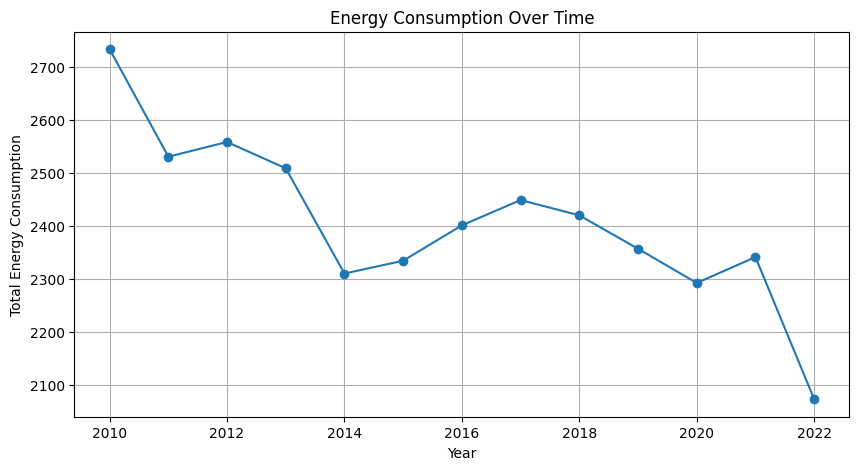

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(merged_data_2['Year'], merged_data_2['TotalEnergyConsumption'], marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Total Energy Consumption")
plt.title("Energy Consumption Over Time")
plt.grid(True)
plt.show()


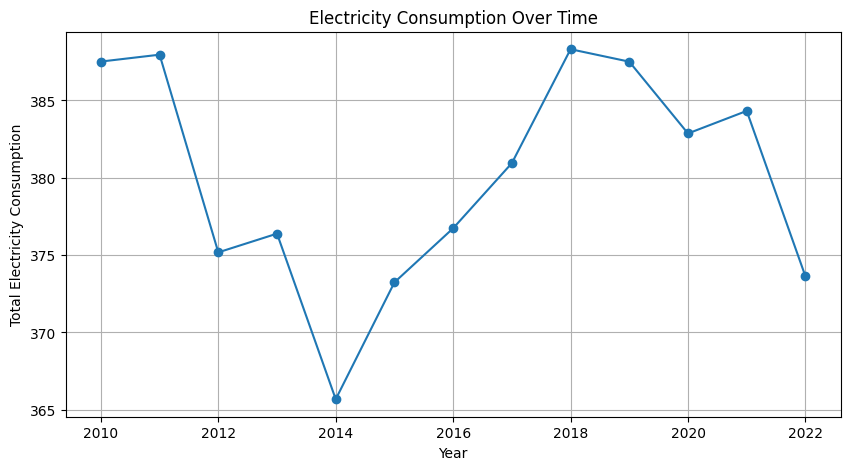

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(merged_data_2['Year'], merged_data_2['ElectricityConsumption'], marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Total Electricity Consumption")
plt.title("Electricity Consumption Over Time")
plt.grid(True)
plt.show()


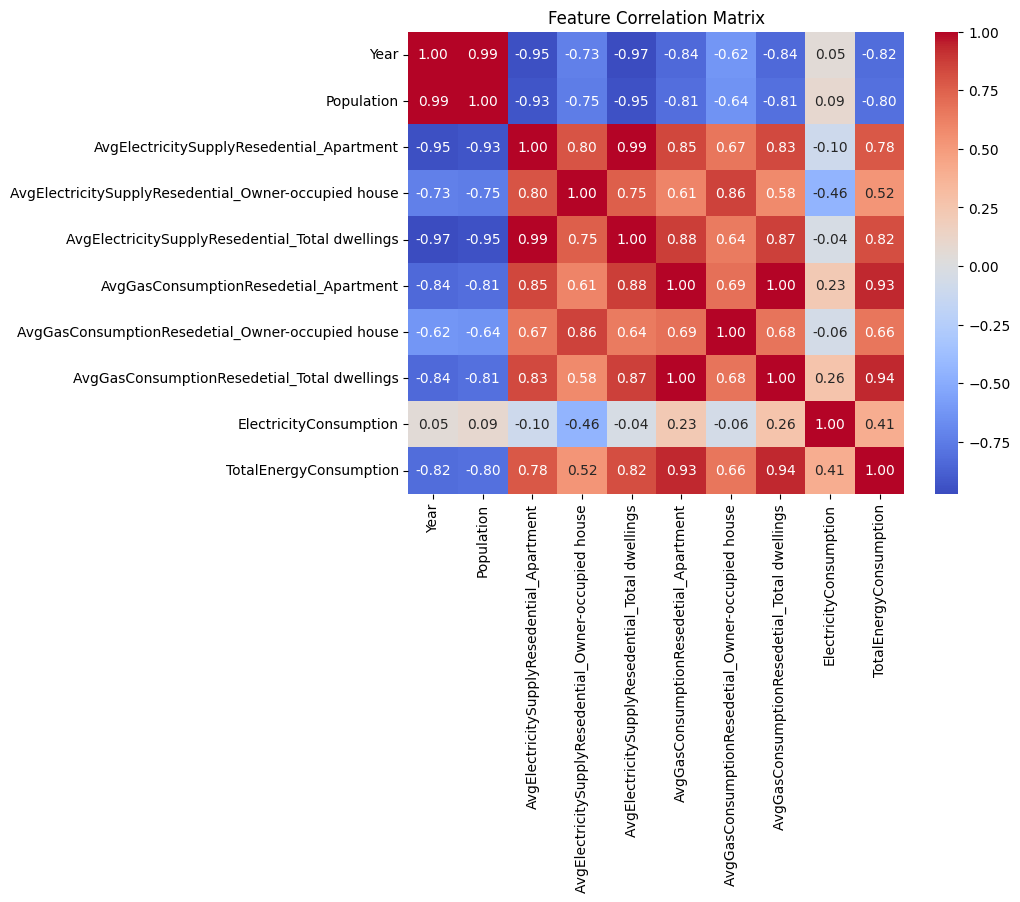

In [35]:
plt.figure(figsize=(8, 6))
sns.heatmap(merged_data_2.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [37]:
merged_data_2.columns

Index(['Year', 'Population', 'AvgElectricitySupplyResedential_Apartment',
       'AvgElectricitySupplyResedential_Owner-occupied house',
       'AvgElectricitySupplyResedential_Total dwellings',
       'AvgGasConsumptionResedetial_Apartment',
       'AvgGasConsumptionResedetial_Owner-occupied house',
       'AvgGasConsumptionResedetial_Total dwellings', 'ElectricityConsumption',
       'TotalEnergyConsumption'],
      dtype='object')

In [38]:
# Define predictors (X) and target variable (y)
X = merged_data_2[['TotalEnergyConsumption', 'Year', 'Population', 'AvgElectricitySupplyResedential_Apartment',
       'AvgElectricitySupplyResedential_Owner-occupied house',
       'AvgElectricitySupplyResedential_Total dwellings',
       'AvgGasConsumptionResedetial_Apartment',
       'AvgGasConsumptionResedetial_Owner-occupied house',
       'AvgGasConsumptionResedetial_Total dwellings']]
y = merged_data_2['ElectricityConsumption']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


In [40]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    print(f"Mean Absolute Error: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"Mean Squared Error: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.2f}")

evaluate_model(y_test, y_pred, "Random Forest Regression")



Random Forest Regression Performance:
Mean Absolute Error: 5.22
Mean Squared Error: 28.37
R² Score: -11.57


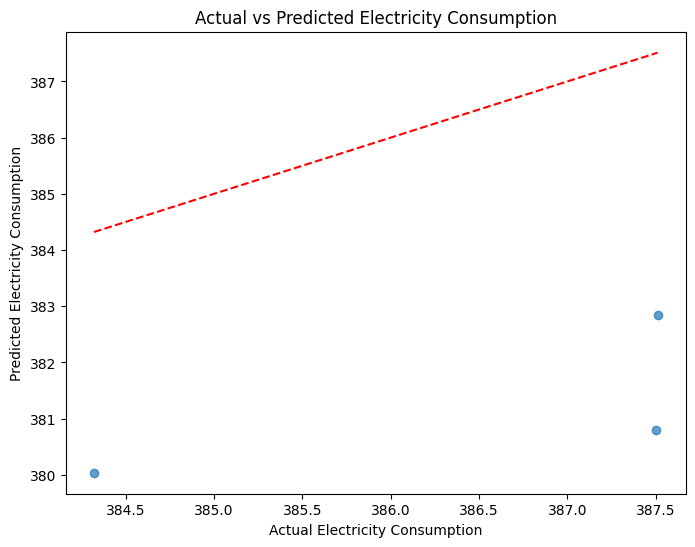

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal fit line
plt.xlabel("Actual Electricity Consumption")
plt.ylabel("Predicted Electricity Consumption")
plt.title("Actual vs Predicted Electricity Consumption")
plt.show()


In [42]:
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                                             Feature  Importance
4  AvgElectricitySupplyResedential_Owner-occupied...    0.278564
1                                               Year    0.135998
5    AvgElectricitySupplyResedential_Total dwellings    0.127782
0                             TotalEnergyConsumption    0.123888
7   AvgGasConsumptionResedetial_Owner-occupied house    0.095107
2                                         Population    0.086486
3          AvgElectricitySupplyResedential_Apartment    0.060430
8        AvgGasConsumptionResedetial_Total dwellings    0.055095
6              AvgGasConsumptionResedetial_Apartment    0.036652


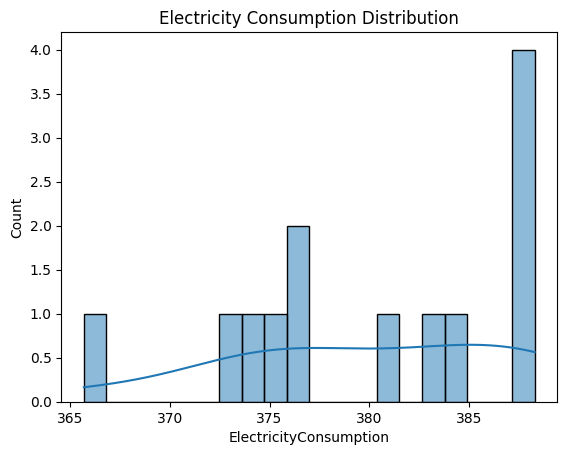

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(merged_data_2['ElectricityConsumption'], bins=20, kde=True)
plt.title("Electricity Consumption Distribution")
plt.show()


In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [45]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

evaluate_model(y_test, y_pred_lr, "Linear Regression")



Linear Regression Performance:
Mean Absolute Error: 154.87
Mean Squared Error: 61426.01
R² Score: -27211.02


In [46]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

evaluate_model(y_test, y_pred_xgb, "XGBoost")



XGBoost Performance:
Mean Absolute Error: 3.40
Mean Squared Error: 17.68
R² Score: -6.83


In [47]:
X = merged_data_2[['AvgElectricitySupplyResedential_Owner-occupied house', 'Year', 
        'AvgGasConsumptionResedetial_Total dwellings', 'TotalEnergyConsumption']]


In [48]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()


In [49]:
from sklearn.linear_model import Ridge, Lasso

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

evaluate_model(y_test, y_pred_ridge, "Ridge Regression")



Ridge Regression Performance:
Mean Absolute Error: 5.95
Mean Squared Error: 51.84
R² Score: -21.97


In [50]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)
evaluate_model(y_test, y_pred_xgb, "XGBoost (Tuned)")


Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

XGBoost (Tuned) Performance:
Mean Absolute Error: 5.48
Mean Squared Error: 32.20
R² Score: -13.27
